In [3]:
import os
import pandas as pd
import numpy as np
import warnings
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns


warnings.filterwarnings("ignore")

# Constants
labels = ['PNEUMONIA', 'NORMAL']
img_size = 128


In [4]:
def preprocess_image(img):
    img = img.convert('L')
    img = img.resize((img_size, img_size))
    img = np.array(img) / 255.0
    return img

def load_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img_name in os.listdir(path):
            if img_name == '.DS_Store':
                continue
            try:
                img_path = os.path.join(path, img_name)
                img = Image.open(img_path)
                img = preprocess_image(img)
                data.append([img, class_num])
            except Exception as e:
                print(f"Error: {e} occurred while processing image: {img_path}")
    return pd.DataFrame(data, columns=['image', 'label'])

print("Loading data...")

train = load_data('../data/train')
test = load_data('../data/test')

X_train = np.stack(train['image'].values)
y_train = np.array(train['label'].tolist())

X_test = np.stack(test['image'].values)
y_test = np.array(test['label'].tolist())

# Add a channel dimension
X_train = X_train.reshape(-1, img_size, img_size, 1)
X_test = X_test.reshape(-1, img_size, img_size, 1)


Loading data...


In [5]:
# Add a channel dimension
X_train = X_train.reshape(-1, img_size, img_size, 1)
X_test = X_test.reshape(-1, img_size, img_size, 1)

# Create an ImageDataGenerator for data augmentation
print("Augmenting data...")
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5]
)

# Initialize an empty list to store augmented data
augmented_data = []

# Generate augmented data batches and concatenate them
batch_size = 256
num_batches = 2  # Number of times to generate augmented data
for _ in range(num_batches):
    for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=batch_size):
        augmented_data.append(X_batch)
        augmented_data.append(y_batch)
        break

# Concatenate augmented data
X_train_augmented = np.concatenate(augmented_data[::2])
y_train_augmented = np.concatenate(augmented_data[1::2])

X_train = np.concatenate((X_train, X_train_augmented))  
y_train = np.concatenate((y_train, y_train_augmented))

print(f"Train NORMAL images: {len(y_train[y_train == 0])}")
print(f"Train PNEUMONIA images: {len(y_train[y_train == 1])}")


Augmenting data...
Train NORMAL images: 4263
Train PNEUMONIA images: 1465


In [6]:
# Reshape data for the model
X_train = X_train.reshape(-1, img_size * img_size)
X_test = X_test.reshape(-1, img_size * img_size)

# Handle class imbalance with SMOTETomek
print("Handling class imbalance...")
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_train, y_train = resample.fit_resample(X_train, y_train)

# Define the model
print("Defining model...")
sc = StandardScaler()
rf = RandomForestClassifier(n_estimators=100, random_state=42)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Train the model
print("Training model...")
rf.fit(X_train, y_train)

# Evaluate the model
print("Evaluating model...")
y_test_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)

Handling class imbalance...
Defining model...
Training model...
Evaluating model...


Confusion Matrix:
[[4258    7]
 [ 120 1455]]


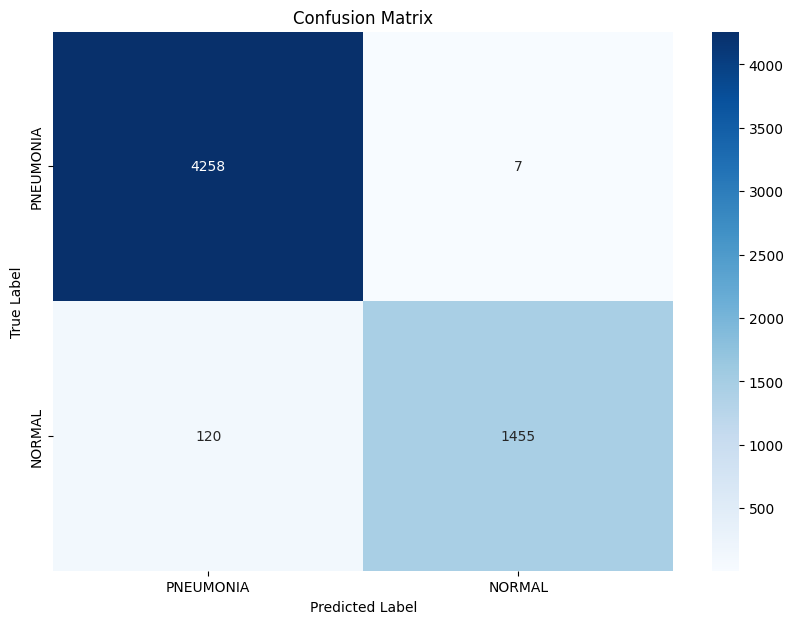

Test Accuracy: 0.9782534246575343

Test Recall: 0.9238095238095239

Test Precision: 0.9952120383036935



In [7]:

# Display results
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(conf_matrix)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred)}\n")

print(f"Test Recall: {recall_score(y_test, y_test_pred)}\n")

print(f"Test Precision: {precision_score(y_test, y_test_pred)}\n")